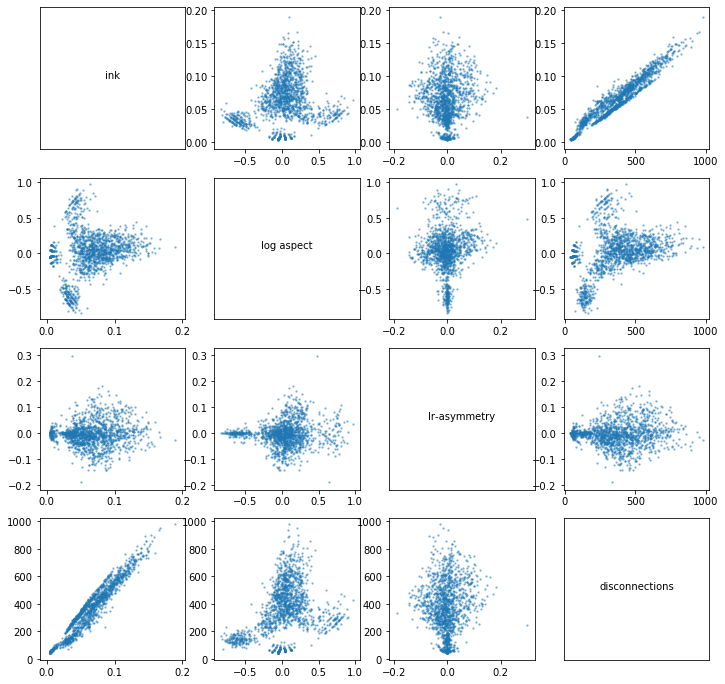

In [3]:
from PIL import Image
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

pngs = sorted(glob.glob('pngs/*.png'))#[:5]  # new cleaned pngs folder after class

h,w,_ = np.array(Image.open(pngs[0])).shape

n = len(pngs)
features = ['ink','log aspect','lr-asymmetry', 'disconnections']
d = len(features)
F = np.empty((d,n))
x = np.arange(0,w) # linspace(0,w,w,endpoint=False)
y = np.arange(0,h) # linspace(0,h,h,endpoint=False)
X,Y = np.meshgrid(x,y)


for k,png in enumerate( pngs ):
        #print(png)
        img = Image.open(png)
        #imshow(img)
        a = np.array(img)
        a = a[:,:,0]  # get just one layer- they are all the same
        a = 255 - a   # invert so character is high values
        ink  = a.sum() / (h*w*255)   # scaled to [0,1]  # maybe too extreme?  # better alternatives
        if ink == 0:
            print('Blank image:',png)
            assert ink>0
        F[0 ,k] = ink

        # height and width of character
        xmin = X[ a>0 ].min()
        xmax = X[ a>0 ].max()
        ymin = Y[ a>0 ].min()
        ymax = Y[ a>0 ].max()
        logaspect = np.log10((ymax-ymin)/(xmax-xmin))
        F[1 ,k] = logaspect

        # left-right asymmetry
        cbbx = (xmin+xmax)/2   # center of bounding box
        cogx = (X*a).sum() / a.sum() # x-coordinate of center of mass of ink
        lrasymmetry = (cogx-cbbx) / (xmax-xmin)
        F[2 ,k] = lrasymmetry
        
        # disconnections  #More disconnections should typically relate to more ink for a character
        flat = np.ravel(a)
        disconnections = 0
        for i in range(len(flat)-1):
            if flat[i] != flat[i+1] and i < len(flat):
                disconnections += 1
        F[3,k] = disconnections

#print(F)
plt.figure(figsize=(12,12))
for i in range(d):
        for j in range(d):
            plt.subplot(d,d,i*d+j+1)
            if i==j:
                plt.text(.5,.5,features[i],ha='center')
                plt.xticks([])
                plt.yticks([])
            else:
                plt.scatter( F[j,:], F[i,:] , s=2, alpha=0.4 )

In [9]:
len(pngs)

1514

In [10]:
pngs[8]

'pngs/000_20191030_eyobtabe__1.png'

In [5]:
# make a list of character classes in pngs
def charclass(png):
    return png.split('__')[1][:-4]

In [6]:
charclasses = {charclass(png) for png in pngs}   # set comprehension
charclasses

{'0', '1', '8', '9', 'C', 'V', 'equals', 'minus', 'period', 'slash'}

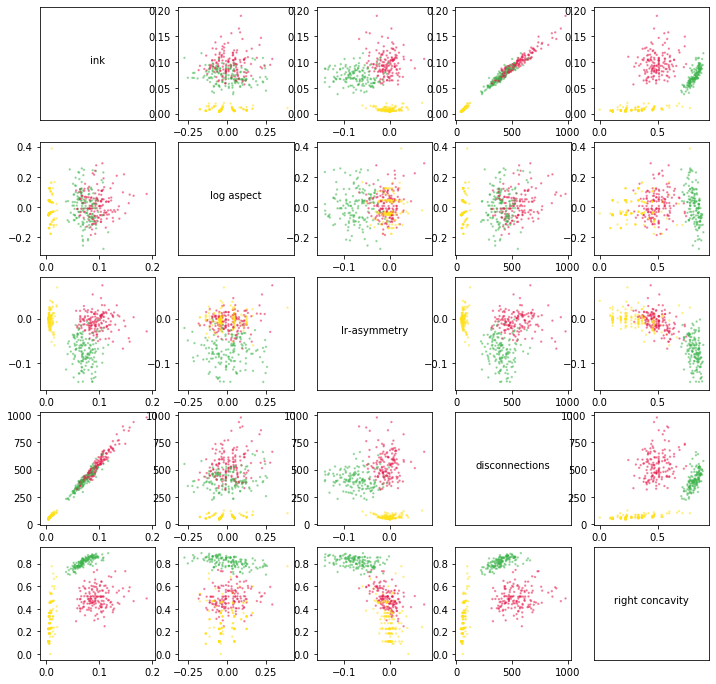

In [80]:
pngs = sorted(glob.glob('pngs/*.png'))#[:5]  # new cleaned pngs folder after class

pngs = [png for png in pngs if charclass(png) in ['C','0','period']]

h,w,_ = np.array(Image.open(pngs[0])).shape

n = len(pngs)
#features = ['ink','log aspect','lr-asymmetry','right concavity']
features = ['ink','log aspect','lr-asymmetry', 'disconnections', 'right concavity']
d = len(features)
F = np.empty((d,n))
x = np.arange(0,w) # linspace(0,w,w,endpoint=False)
y = np.arange(0,h) # linspace(0,h,h,endpoint=False)
X,Y = np.meshgrid(x,y)


for k,png in enumerate( pngs ):
        #print(png)
        img = Image.open(png)
        #imshow(img)
        a = np.array(img)
        a = a[:,:,0]  # get just one layer- they are all the same
        a = 255 - a   # invert so character is high values
        ink  = a.sum() / (h*w*255)   # scaled to [0,1]  # maybe too extreme?  # better alternatives
        if ink == 0:
            print('Blank image:',png)
            assert ink>0
        F[0 ,k] = ink

        # height and width of character
        xmin = X[ a>0 ].min()
        xmax = X[ a>0 ].max()
        ymin = Y[ a>0 ].min()
        ymax = Y[ a>0 ].max()
        logaspect = np.log10((ymax-ymin)/(xmax-xmin))
        F[1 ,k] = logaspect

        # left-right asymmetry
        cbbx = (xmin+xmax)/2   # center of bounding box
        cogx = (X*a).sum() / a.sum() # x-coordinate of center of mass of ink
        lrasymmetry = (cogx-cbbx) / (xmax-xmin)
        F[2 ,k] = lrasymmetry
        
        #disconnections        
        flat = np.ravel(a)
        disconnections = 0
        for i in range(len(flat)-1):
            if flat[i] != flat[i+1] and i < len(flat):
                disconnections += 1
        F[3,k] = disconnections
        
        # right concavity
        xstar = w - np.argmax( np.fliplr(a) > 0, axis=1 ).max()
        F[4, k] = (xmax-xstar)/(xmax-xmin)
        
        
#print(F)

colors21  = ['#e6194b', '#3cb44b', '#ffe119', 
             '#4363d8', '#f58231', '#911eb4', 
             '#46f0f0', '#f032e6', '#bcf60c', 
             '#fabebe', '#008080', '#e6beff', 
             '#9a6324', '#fffac8', '#800000', 
             '#aaffc3', '#808000', '#ffd8b1', 
             '#000075', '#808080', '#000000']

# make a list of character classes in pngs
def charclass(png):
    return png.split('__')[1][:-4]

charclasses = sorted({charclass(png) for png in pngs})   # set comprehension
cmap = {cc:color for cc,color in zip(charclasses,colors21)}
colors = [cmap[charclass(png)] for png in pngs]

plt.figure(figsize=(12,12))
for i in range(d):
        for j in range(d):
            plt.subplot(d,d,i*d+j+1)
            if i==j:
                plt.text(.5,.5,features[i],ha='center')
                plt.xticks([])
                plt.yticks([])
            else:
                plt.scatter( F[j,:], F[i,:] , s=2, c=colors, alpha=0.4 )

# Method of K-"means"

To split a cloud of points (our feature vectors) into k-clusters (number of clusters is chosen). The "means" are special points that are the centroids of the clusters. An iterative process.

1. Start with some sensible initial choice of the means. 

2. Assign points to a cluster according to which man each is closest to

3. Reassign the means as the centroids of the cluster

4. If a change in assignment happened, then repeat

In [22]:
F.shape

(4, 454)

In [63]:
FT = F.T
#let's begin by rescaling the data to lie in the unit square
FT -= FT.min(axis=0)
FT /= FT.max(axis=0)

k=3
#means = (classes, features)
means = np.random.rand(k,4)
means

array([[0.04352409, 0.92800255, 0.68604458, 0.71945464],
       [0.70477438, 0.35970258, 0.69708894, 0.94626749],
       [0.27984279, 0.34385856, 0.34558996, 0.52083635]])

In [64]:
FT.shape, means.shape

((454, 4), (3, 4))

In [65]:
FT[:,:,np.newaxis].shape

(454, 4, 1)

In [66]:
displacements = FT[:,:,np.newaxis] - means.T
displacements.shape
(displacements**2).sum(axis=1).shape
#make an assignment array
assignments = np.argmin( (displacements**2).sum(axis=1), axis = 1)
assignments

array([2, 2, 2, 2, 2, 2, 0, 2, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1,
       1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2,
       2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       2, 2, 2, 2, 2, 2, 1, 1, 0, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2,
       0, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,

In [67]:
#After class - wrapped it up in a function

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1,

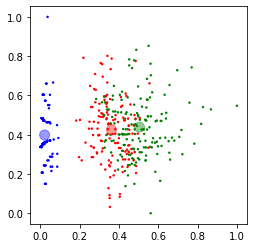

In [78]:
def kmeans(FT,k):
    n = FT.shape[0]
    #means = np.random.rand(k,2)
    means = FT[ np.random.choice(range(n),k,replace=False), : ] # choose 3 random data points
                                                                # so that there's at least 1 point in each cluster
    prevassignments = k*np.ones(n)  # start with assignments that could never happen
    while True:
        displacements = FT[:,:,np.newaxis] - means.T
        assignments = np.argmin( (displacements**2).sum(axis=1), axis=1 )# index of the mean that is closest to each point
        if np.array_equal( assignments, prevassignments ): 
            break
        # reset the "means" to be the means of the clusters defined the new assignments
        for i in range(k):
            means[i] = FT[ assignments==i , :].mean(axis=0)
        prevassignments = assignments
    kmap = {0:'r',1:'g',2:'b'}
    plt.subplot(aspect=1)
    plt.scatter(FT[:,0],FT[:,1],c=[kmap[a] for a in assignments],s=2)
    plt.scatter( means[:,0],means[:,1],c='rgb',s=100, alpha=0.4 )
    return assignments

kmeans(FT,3)

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 2,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2,

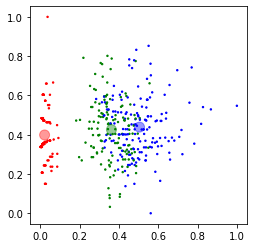

In [79]:
kmeans(FT, 3)